In [1]:
# coding=utf-8
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
#load MNIST data
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
MNIST_data.close()

In [3]:
class FullyConnectedLayer(object):
    
    def __init__(self, num_input, num_output):  # 全连接层初始化
        self.num_input = num_input
        self.num_output = num_output
        print('\tFully connected layer with input %d, output %d.' % (self.num_input, self.num_output))
        
    def init_param(self, std=0.01):  # 参数初始化
        #w，b初始值一定不能是全0，否则梯度永远是0，无法更新。
        self.weight = np.random.normal(loc=0.0, scale=std, size=(self.num_input, self.num_output))
        self.bias = np.zeros([1, self.num_output])
        
    def forward(self, input):  # 前向传播计算
        self.input = input
        # TODO：全连接层的前向传播，计算输出结果
        self.output = np.matmul(input, self.weight) + self.bias
        return self.output
        """
        X:  输入数据,(N X input_D）的矩阵
        返回值：    (N X output_D）的矩阵，传往下一层
        """
    
    def backward(self, top_diff):  # 反向传播的计算
        # TODO：全连接层的反向传播，计算参数梯度和本层损失
        self.d_weight = np.dot(self.input.T, top_diff)
        self.d_bias = np.sum(top_diff, axis=0)
        bottom_diff = np.dot(top_diff, self.weight.T)
        return bottom_diff
        """
        X:    输入数据，（N X input_D）的矩阵
        grad: 反向传播过来的梯度，(N X output_D) 的向量
        返回值:梯度，(N X input_D)的矩阵，传往上一层
        """
    
    def update_param(self, lr):  # 参数更新
        # TODO：对全连接层参数利用参数进行更新
        self.weight = self.weight - lr*self.d_weight
        self.bias = self.bias - lr*self.d_bias
        
    def load_param(self, weight, bias):  # 参数加载
        assert self.weight.shape == weight.shape
        assert self.bias.shape == bias.shape
        self.weight = weight
        self.bias = bias
        
    def save_param(self):  # 参数保存
        return self.weight, self.bias
    

In [4]:
class ReLULayer(object):
    
    def __init__(self):
        print('\tReLU layer.')
        
    def forward(self, input):  # 前向传播的计算
        self.input = input
        # TODO：ReLU层的前向传播，计算输出结果
        output = np.maximum(0, input)
        return output
    
    def backward(self, top_diff):  # 反向传播的计算
        # TODO：ReLU层的反向传播，计算本层损失
        bottom_diff = top_diff
        bottom_diff[self.input<0] = 0
        return bottom_diff
    

In [5]:
class SoftmaxLossLayer(object):
    
    def __init__(self):
        print('\tSoftmax loss layer.')
        
    def forward(self, input):  # 前向传播的计算
        # TODO：softmax 损失层的前向传播，计算输出结果
        input_max = np.max(input, axis=1, keepdims=True)
        input_exp = np.exp(input - input_max)
        self.prob = input_exp / np.sum(input_exp, axis=1, keepdims=True)
        return self.prob
    
    def get_loss(self, label):   # 计算损失
        self.batch_size = self.prob.shape[0]
        self.label_onehot = np.zeros_like(self.prob)
        self.label_onehot[np.arange(self.batch_size), label] = 1.0
        loss = -np.sum(np.log(self.prob) * self.label_onehot) / self.batch_size
        return loss
    
    def backward(self):  # 反向传播的计算
        # TODO：softmax 损失层的反向传播，计算本层损失
        bottom_diff = (self.prob - self.label_onehot) / self.batch_size
        return bottom_diff
    

In [12]:
# coding=utf-8

lr_list = [0.001, 0.01, 0.1]  # 学习率
hidden1 = [300, 200, 100]   # 隐藏层大小

loss_ = []
acc_ = []

class MNIST_MLP(object):
    
    def __init__(self, batch_size=30, input_size=784, hidden1=192, out_classes=10, lr=0.01, max_epoch=30, print_iter=1000, ):
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden1 = hidden1
        self.out_classes = out_classes
        self.lr = lr
        self.max_epoch = max_epoch
        self.print_iter = print_iter

    def load_data(self):
        print('Loading MNIST data from csv...')
        self.train_data = np.append(x_train, y_train.reshape(-1,1), axis=1)
        self.test_data = np.append(x_test, y_test.reshape(-1,1), axis=1)
        

    def shuffle_data(self):
        print('Randomly shuffle MNIST data...')
        np.random.shuffle(self.train_data)

    def build_model(self):  # 建立网络结构
        # 建立两层神经网络结构
        print('Building multi-layer perception model...')
        self.fc1 = FullyConnectedLayer(self.input_size, self.hidden1)
        self.relu1 = ReLULayer()
        self.fc2 = FullyConnectedLayer(self.hidden1, self.out_classes)
        self.softmax = SoftmaxLossLayer()
        self.update_layer_list = [self.fc1, self.fc2]

    def init_model(self):
        print('Initializing parameters of each layer in MLP...')
        for layer in self.update_layer_list:
            layer.init_param()

    def load_model(self, param_dir):
        print('Loading parameters from file ' + param_dir)
        params = np.load(param_dir).item()
        self.fc1.load_param(params['w1'], params['b1'])
        self.fc2.load_param(params['w2'], params['b2'])

    def save_model(self, param_dir):
        print('Saving parameters to file ' + param_dir)
        params = {}
        params['w1'], params['b1'] = self.fc1.save_param()
        params['w2'], params['b2'] = self.fc2.save_param()
        np.save(param_dir, params)

    def forward(self, input):  # 神经网络的前向传播
        # 神经网络的前向传播
        h1 = self.fc1.forward(input)
        h1 = self.relu1.forward(h1)
        h2 = self.fc2.forward(h1)
        prob = self.softmax.forward(h2)
        return prob

    def backward(self):  # 神经网络的反向传播
        # 神经网络的反向传播
        dloss = self.softmax.backward()
        dh2 = self.fc2.backward(dloss)
        dh1 = self.relu1.backward(dh2)
        dh1 = self.fc1.backward(dh1)

    def update(self, lr):
        for layer in self.update_layer_list:
            layer.update_param(lr)

    def train(self):
        max_batch = self.train_data.shape[0] // self.batch_size
        print('Start training...')
        for idx_epoch in range(self.max_epoch):
            self.shuffle_data()
            for idx_batch in range(max_batch):
                batch_images = self.train_data[idx_batch*self.batch_size:(idx_batch+1)*self.batch_size, :-1]
                batch_labels = np.int_(self.train_data[idx_batch*self.batch_size:(idx_batch+1)*self.batch_size, -1])
                prob = self.forward(batch_images)
                loss = self.softmax.get_loss(batch_labels)
                self.backward()
                self.update(self.lr)
                if idx_batch % self.print_iter == 0:
                    
                    pred_results = np.zeros([self.test_data.shape[0]])
                    for idx in range(self.test_data.shape[0]//self.batch_size):
                        batch_images = self.test_data[idx*self.batch_size:(idx+1)*self.batch_size, :-1]
                        prob = self.forward(batch_images)
                        pred_labels = np.argmax(prob, axis=1)
                        pred_results[idx*self.batch_size:(idx+1)*self.batch_size] = pred_labels
                    accuracy = np.mean(pred_results == self.test_data[:,-1])
                    
                    loss_.append(loss)
                    acc_.append(accuracy)
                    
                    print('Iterations: %d, loss: %.6f, Accuracy in testing set: %f' % (idx_epoch*2000 + idx_batch, loss, accuracy))
                    

def build_mnist_mlp(param_dir='weight.npy', h1=h1, lr=lr):
    mlp = MNIST_MLP(hidden1=h1, lr=lr)
    mlp.load_data()
    mlp.build_model()
    mlp.init_model()
    mlp.train()
    mlp.save_model('h1-%d_lr-%f.npy' % (h1, lr))
    return mlp

if __name__ == '__main__':
    for i in range(len(hidden1)):
        for j in range(len(lr_list)):
                e = 20
                h1 = hidden1[i]
                lr = lr_list[j]
                mlp = build_mnist_mlp(h1=h1, lr=lr)


Loading MNIST data from csv...
Building multi-layer perception model...
	Fully connected layer with input 784, output 300.
	ReLU layer.
	Fully connected layer with input 300, output 10.
	Softmax loss layer.
Initializing parameters of each layer in MLP...
Start training...
Randomly shuffle MNIST data...
Iterations: 0, loss: 2.306346, Accuracy in testing set: 0.096500
Iterations: 1000, loss: 2.276843, Accuracy in testing set: 0.496600
Randomly shuffle MNIST data...
Iterations: 2000, loss: 2.237777, Accuracy in testing set: 0.602700
Iterations: 3000, loss: 2.140102, Accuracy in testing set: 0.629500
Randomly shuffle MNIST data...
Iterations: 4000, loss: 1.909130, Accuracy in testing set: 0.649300
Iterations: 5000, loss: 1.739757, Accuracy in testing set: 0.687200
Randomly shuffle MNIST data...
Iterations: 6000, loss: 1.354949, Accuracy in testing set: 0.723700
Iterations: 7000, loss: 1.305690, Accuracy in testing set: 0.764400
Randomly shuffle MNIST data...
Iterations: 8000, loss: 0.93937

Iterations: 30000, loss: 0.062393, Accuracy in testing set: 0.956600
Iterations: 31000, loss: 0.187774, Accuracy in testing set: 0.958000
Randomly shuffle MNIST data...
Iterations: 32000, loss: 0.169356, Accuracy in testing set: 0.957800
Iterations: 33000, loss: 0.030793, Accuracy in testing set: 0.959000
Randomly shuffle MNIST data...
Iterations: 34000, loss: 0.239854, Accuracy in testing set: 0.960100
Iterations: 35000, loss: 0.150425, Accuracy in testing set: 0.960200
Randomly shuffle MNIST data...
Iterations: 36000, loss: 0.131449, Accuracy in testing set: 0.960400
Iterations: 37000, loss: 0.056398, Accuracy in testing set: 0.960600
Randomly shuffle MNIST data...
Iterations: 38000, loss: 0.083634, Accuracy in testing set: 0.961600
Iterations: 39000, loss: 0.203432, Accuracy in testing set: 0.962800
Randomly shuffle MNIST data...
Iterations: 40000, loss: 0.102352, Accuracy in testing set: 0.963300
Iterations: 41000, loss: 0.283814, Accuracy in testing set: 0.964100
Randomly shuffle 

Iterations: 0, loss: 2.302771, Accuracy in testing set: 0.086300
Iterations: 1000, loss: 2.288117, Accuracy in testing set: 0.425600
Randomly shuffle MNIST data...
Iterations: 2000, loss: 2.257209, Accuracy in testing set: 0.499500
Iterations: 3000, loss: 2.183412, Accuracy in testing set: 0.511400
Randomly shuffle MNIST data...
Iterations: 4000, loss: 2.073413, Accuracy in testing set: 0.573800
Iterations: 5000, loss: 1.800857, Accuracy in testing set: 0.660000
Randomly shuffle MNIST data...
Iterations: 6000, loss: 1.538317, Accuracy in testing set: 0.712400
Iterations: 7000, loss: 1.346667, Accuracy in testing set: 0.736200
Randomly shuffle MNIST data...
Iterations: 8000, loss: 1.007661, Accuracy in testing set: 0.773800
Iterations: 9000, loss: 0.939666, Accuracy in testing set: 0.795200
Randomly shuffle MNIST data...
Iterations: 10000, loss: 0.826909, Accuracy in testing set: 0.808800
Iterations: 11000, loss: 0.864809, Accuracy in testing set: 0.824000
Randomly shuffle MNIST data...

Randomly shuffle MNIST data...
Iterations: 34000, loss: 0.064556, Accuracy in testing set: 0.959200
Iterations: 35000, loss: 0.114235, Accuracy in testing set: 0.960200
Randomly shuffle MNIST data...
Iterations: 36000, loss: 0.309501, Accuracy in testing set: 0.960300
Iterations: 37000, loss: 0.141804, Accuracy in testing set: 0.961400
Randomly shuffle MNIST data...
Iterations: 38000, loss: 0.067369, Accuracy in testing set: 0.961400
Iterations: 39000, loss: 0.397990, Accuracy in testing set: 0.962400
Randomly shuffle MNIST data...
Iterations: 40000, loss: 0.294855, Accuracy in testing set: 0.963600
Iterations: 41000, loss: 0.092822, Accuracy in testing set: 0.963100
Randomly shuffle MNIST data...
Iterations: 42000, loss: 0.120060, Accuracy in testing set: 0.963500
Iterations: 43000, loss: 0.189257, Accuracy in testing set: 0.964600
Randomly shuffle MNIST data...
Iterations: 44000, loss: 0.082433, Accuracy in testing set: 0.965300
Iterations: 45000, loss: 0.057550, Accuracy in testing 

Randomly shuffle MNIST data...
Iterations: 4000, loss: 2.162424, Accuracy in testing set: 0.614100
Iterations: 5000, loss: 2.042306, Accuracy in testing set: 0.622700
Randomly shuffle MNIST data...
Iterations: 6000, loss: 1.855261, Accuracy in testing set: 0.665100
Iterations: 7000, loss: 1.504039, Accuracy in testing set: 0.697700
Randomly shuffle MNIST data...
Iterations: 8000, loss: 1.268071, Accuracy in testing set: 0.726500
Iterations: 9000, loss: 1.003868, Accuracy in testing set: 0.762600
Randomly shuffle MNIST data...
Iterations: 10000, loss: 1.066995, Accuracy in testing set: 0.785600
Iterations: 11000, loss: 0.904067, Accuracy in testing set: 0.799800
Randomly shuffle MNIST data...
Iterations: 12000, loss: 1.063761, Accuracy in testing set: 0.814100
Iterations: 13000, loss: 0.572269, Accuracy in testing set: 0.825700
Randomly shuffle MNIST data...
Iterations: 14000, loss: 0.497157, Accuracy in testing set: 0.837200
Iterations: 15000, loss: 0.476876, Accuracy in testing set: 0

Randomly shuffle MNIST data...
Iterations: 38000, loss: 0.118947, Accuracy in testing set: 0.956700
Iterations: 39000, loss: 0.231341, Accuracy in testing set: 0.957700
Randomly shuffle MNIST data...
Iterations: 40000, loss: 0.049350, Accuracy in testing set: 0.958200
Iterations: 41000, loss: 0.281341, Accuracy in testing set: 0.959000
Randomly shuffle MNIST data...
Iterations: 42000, loss: 0.050302, Accuracy in testing set: 0.958300
Iterations: 43000, loss: 0.157926, Accuracy in testing set: 0.960300
Randomly shuffle MNIST data...
Iterations: 44000, loss: 0.045783, Accuracy in testing set: 0.959700
Iterations: 45000, loss: 0.190978, Accuracy in testing set: 0.961300
Randomly shuffle MNIST data...
Iterations: 46000, loss: 0.074832, Accuracy in testing set: 0.961500
Iterations: 47000, loss: 0.202510, Accuracy in testing set: 0.961000
Randomly shuffle MNIST data...
Iterations: 48000, loss: 0.049846, Accuracy in testing set: 0.962400
Iterations: 49000, loss: 0.039657, Accuracy in testing 

In [13]:
h300_lr001_loss = loss_[0:60]
h300_lr01_loss = loss_[60:120]
h300_lr1_loss = loss_[120:180]
h200_lr001_loss = loss_[180:240]
h200_lr01_loss = loss_[240:300]
h200_lr1_loss = loss_[300:360]
h100_lr001_loss = loss_[360:420]
h100_lr01_loss = loss_[420:480]
h100_lr1_loss = loss_[480:540]

h300_lr001_acc = acc_[0:60]
h300_lr01_acc = acc_[60:120]
h300_lr1_acc = acc_[120:180]
h200_lr001_acc = acc_[180:240]
h200_lr01_acc = acc_[240:300]
h200_lr1_acc = acc_[300:360]
h100_lr001_acc = acc_[360:420]
h100_lr01_acc = acc_[420:480]
h100_lr1_acc = acc_[480:540]

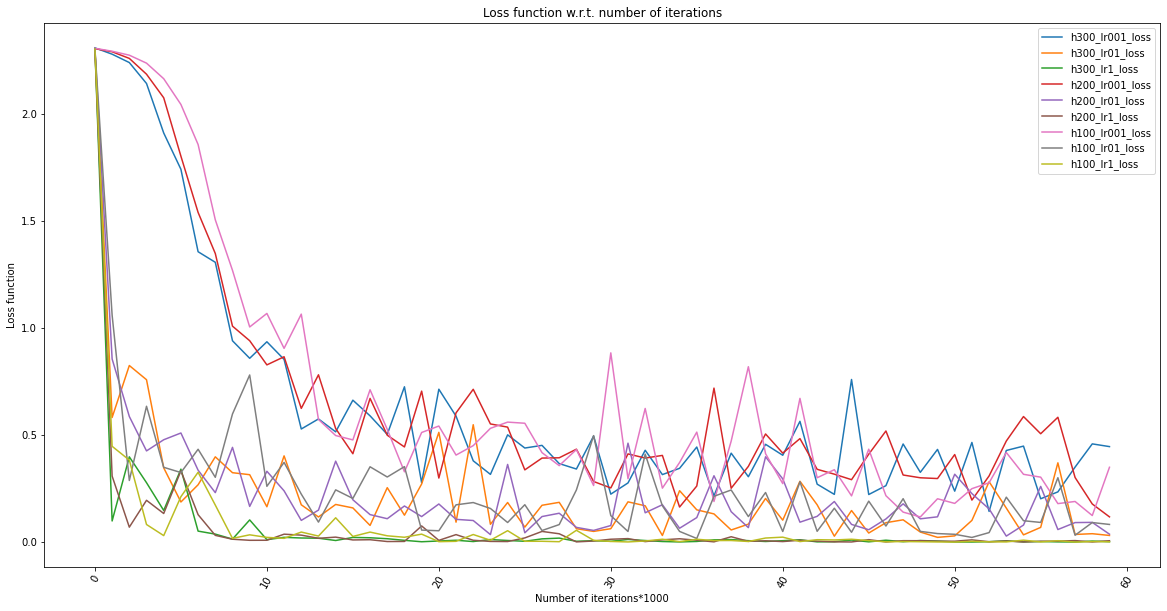

In [14]:
plt.figure(figsize=(20,10))
plt.plot(h300_lr001_loss, label = "h300_lr001_loss")
plt.plot(h300_lr01_loss, label = "h300_lr01_loss")
plt.plot(h300_lr1_loss, label = "h300_lr1_loss")
plt.plot(h200_lr001_loss, label = "h200_lr001_loss")
plt.plot(h200_lr01_loss, label = "h200_lr01_loss")
plt.plot(h200_lr1_loss, label = "h200_lr1_loss")
plt.plot(h100_lr001_loss, label = "h100_lr001_loss")
plt.plot(h100_lr01_loss, label = "h100_lr01_loss")
plt.plot(h100_lr1_loss, label = "h100_lr1_loss")
plt.ylabel('Loss function')
plt.xlabel('Number of iterations*1000')
plt.xticks(rotation=60)
plt.title('Loss function w.r.t. number of iterations')
plt.legend(['h300_lr001_loss', 'h300_lr01_loss', 'h300_lr1_loss', 'h200_lr001_loss', 'h200_lr01_loss', 'h200_lr1_loss', 'h100_lr001_loss', 'h100_lr01_loss', 'h100_lr1_loss'])
plt.show()

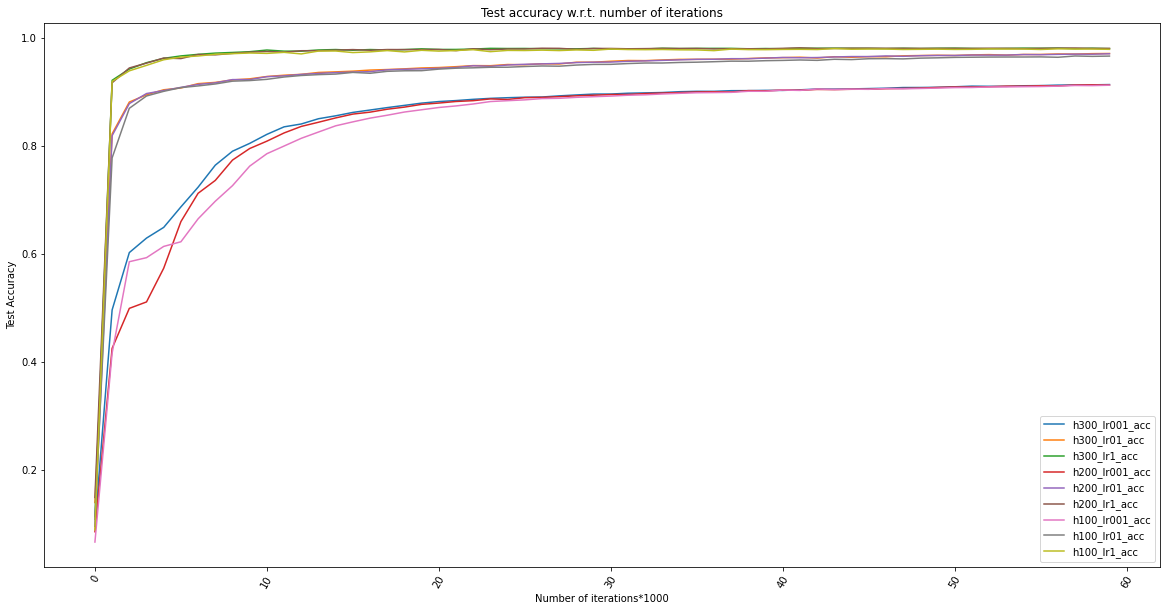

In [15]:
plt.figure(figsize=(20,10))
plt.plot(h300_lr001_acc, label = "h300_lr001_acc")
plt.plot(h300_lr01_acc, label = "h300_lr01_acc")
plt.plot(h300_lr1_acc, label = "h300_lr1_acc")
plt.plot(h200_lr001_acc, label = "h200_lr001_acc")
plt.plot(h200_lr01_acc, label = "h200_lr01_acc")
plt.plot(h200_lr1_acc, label = "h200_lr1_acc")
plt.plot(h100_lr001_acc, label = "h100_lr001_acc")
plt.plot(h100_lr01_acc, label = "h100_lr01_acc")
plt.plot(h100_lr1_acc, label = "h100_lr1_acc")
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations*1000')
plt.xticks(rotation=60)
plt.title('Test accuracy w.r.t. number of iterations')
plt.legend(['h300_lr001_acc', 'h300_lr01_acc', 'h300_lr1_acc', 'h200_lr001_acc', 'h200_lr01_acc', 'h200_lr1_acc', 'h100_lr001_acc', 'h100_lr01_acc', 'h100_lr1_acc'])
plt.show()